In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
def preprocess_design_matrix(design_matrix):


    design_matrix = design_matrix[
        (design_matrix['verified_infection'] == 1.0) |
        (design_matrix['no_infection'] == 1.0) 
    ].copy()
    # design_matrix.shape
    design_matrix['group'] = np.where(
        design_matrix['verified_infection'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [4]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [5]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [6]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='verified_infection', ylabel='Count'>

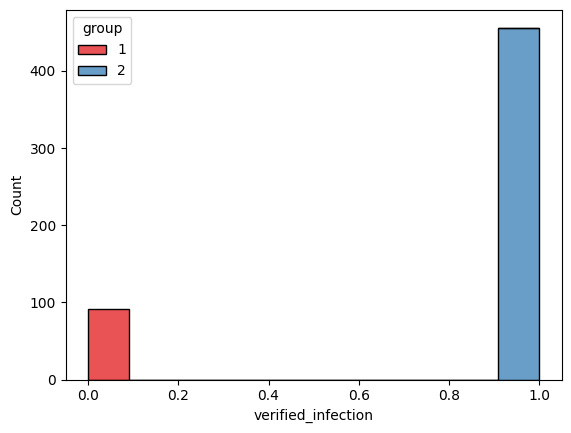

In [7]:
sns.histplot(
    design_matrix_train,
    x="verified_infection",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [8]:
design_matrix_train['group'].value_counts()

group
2    456
1     92
Name: count, dtype: int64

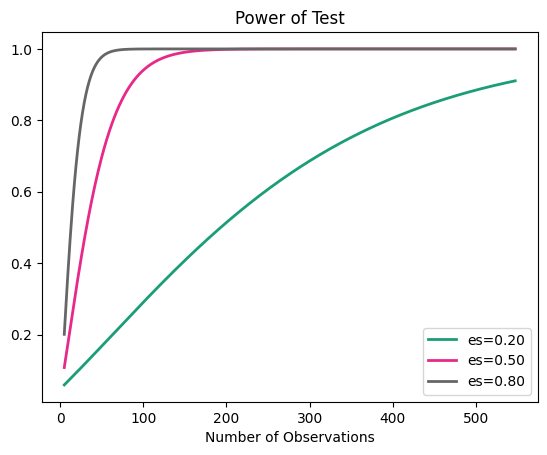

In [9]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [10]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [11]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [12]:
quant_matrix_train.write("de_results/infection_de_proteins.tsv")

In [13]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

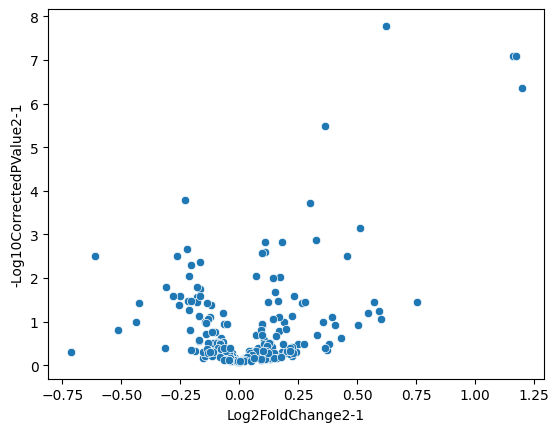

In [14]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [15]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [16]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [17]:
protein_columns = training_data.columns.to_list()

In [18]:
len(protein_columns)

287

In [19]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [21]:
y['label'].value_counts()

label
1    456
0     92
Name: count, dtype: int64

In [22]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 2.9782608695652173, 1: 0.6008771929824561}

In [23]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [24]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


In [25]:
selected_proteins

['LBP_HUMAN',
 'MASP1_HUMAN',
 'K2C1_HUMAN',
 'CRP_HUMAN',
 'PIGR_HUMAN',
 'SAA1_HUMAN',
 'FUCO_HUMAN',
 'VWF_HUMAN',
 'A2GL_HUMAN',
 'APOB_HUMAN',
 'SAA2_HUMAN',
 'TAGL2_HUMAN',
 'APOA_HUMAN',
 'CLUS_HUMAN',
 'PROC_HUMAN',
 'A1AT_HUMAN',
 'ZPI_HUMAN',
 'LIRB1_HUMAN',
 'CBPB2_HUMAN',
 'AACT_HUMAN',
 'C163A_HUMAN',
 'FGL1_HUMAN',
 'SPP24_HUMAN',
 'ALS_HUMAN',
 'FIBB_HUMAN',
 'NCHL1_HUMAN',
 'CBPN_HUMAN',
 'FIBA_HUMAN',
 'TIMP1_HUMAN',
 'FLNA_HUMAN',
 'KAIN_HUMAN',
 'MA1A1_HUMAN',
 'CATD_HUMAN',
 'APOM_HUMAN',
 'MYL6_HUMAN',
 'FCG3A_HUMAN',
 'PCSK9_HUMAN',
 'FBLN5_HUMAN',
 'APOC3_HUMAN',
 'FIBG_HUMAN',
 'ITIH2_HUMAN',
 'H4_HUMAN',
 'LYAM1_HUMAN',
 'ANT3_HUMAN',
 'VCAM1_HUMAN',
 'FINC_HUMAN',
 'IPSP_HUMAN',
 'RET4_HUMAN',
 'CD14_HUMAN',
 'PGRP2_HUMAN']

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [27]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7346491228070176,
 0.8936396396396397,
 0.7043275485898436,
 0.6452815506508206)

In [28]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [29]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [30]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [31]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
4,PIGR_HUMAN,0.871272,4.0,0.926122,4.0,0.654519,5.0,0.818931,3.0,0.636130,...,0.019525,47.0,0.745588,3.0,0.717273,0.742221,0.239324,6.74,5.0,7.855539
26,CBPN_HUMAN,0.679365,11.0,0.984884,3.0,0.116966,43.0,0.895390,2.0,0.977774,...,0.119792,31.0,0.455114,10.0,0.620582,0.664924,0.303428,11.58,6.0,13.043192
0,LBP_HUMAN,0.517703,15.0,0.992275,2.0,1.000000,1.0,0.177682,37.0,0.041678,...,0.113147,33.0,0.715648,4.0,0.457325,0.424563,0.286713,17.46,13.0,13.989477
7,VWF_HUMAN,0.126577,43.0,0.352836,29.0,0.778682,2.0,0.387389,16.0,0.458032,...,0.512288,5.0,0.412020,11.0,0.456754,0.426133,0.276055,17.26,13.5,13.893258
39,FIBG_HUMAN,1.000000,1.0,1.000000,1.0,0.337499,21.0,0.304920,25.0,0.477539,...,0.992523,2.0,0.123505,35.0,0.437286,0.358282,0.314793,19.66,18.0,15.001832
6,FUCO_HUMAN,0.383751,21.0,0.545358,21.0,0.498223,13.0,0.162087,39.0,0.676440,...,0.240043,16.0,0.586090,7.0,0.437202,0.385543,0.246208,17.47,15.0,12.650272
37,FBLN5_HUMAN,0.683854,10.0,0.538077,22.0,0.434851,15.0,0.766873,4.0,0.800821,...,0.101907,34.0,1.000000,1.0,0.432534,0.382996,0.271363,18.41,14.5,13.820710
10,SAA2_HUMAN,0.798781,6.0,0.367100,28.0,0.589443,8.0,0.222894,33.0,0.069540,...,0.472779,6.0,0.085565,38.0,0.416732,0.358765,0.276315,19.81,19.5,14.032210
16,ZPI_HUMAN,0.533426,14.0,0.174115,41.0,0.679567,4.0,0.463035,11.0,0.802898,...,0.315601,10.0,0.620738,6.0,0.386656,0.351034,0.228689,19.78,17.0,13.025678
45,FINC_HUMAN,0.011735,50.0,0.669817,11.0,0.383342,17.0,0.696551,6.0,0.526601,...,0.141946,27.0,0.748234,2.0,0.384334,0.318181,0.266972,21.79,20.0,15.056993


In [32]:
selected_proteins = protein_importances.head(20)['feature'].to_list()

In [33]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [34]:
selected_features = selected_proteins[:10]

In [35]:
for feature in selected_features:

    print(feature)

PIGR_HUMAN
CBPN_HUMAN
LBP_HUMAN
VWF_HUMAN
FIBG_HUMAN
FUCO_HUMAN
FBLN5_HUMAN
SAA2_HUMAN
ZPI_HUMAN
FINC_HUMAN


In [36]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6951754385964911,
 0.9183281473604055,
 0.6934386196681279,
 0.6909568949254857)

In [38]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7565789473684209,
 0.8323621401428166,
 0.6696791368922517,
 0.4985403697415582)

In [39]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [40]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [41]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [42]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
9,FINC_HUMAN,0.450769,4.0,1.000000,1.0,0.566921,4.0,0.985583,2.0,0.823214,...,0.745301,2.0,1.000000,1.0,0.833495,0.922546,0.205707,2.33,2.0,1.504572
2,LBP_HUMAN,1.000000,1.0,0.915142,2.0,0.727030,3.0,0.413058,5.0,0.422507,...,1.000000,1.0,0.380204,8.0,0.738440,0.857259,0.286792,3.24,2.0,2.586367
0,PIGR_HUMAN,0.891837,2.0,0.888839,3.0,0.744731,2.0,1.000000,1.0,1.000000,...,0.402295,4.0,0.886333,2.0,0.726269,0.746244,0.213603,3.10,3.0,1.629897
3,VWF_HUMAN,0.286281,6.0,0.565709,5.0,1.000000,1.0,0.488805,4.0,0.308734,...,0.538095,3.0,0.520904,6.0,0.613857,0.610486,0.238273,4.37,4.0,2.250275
6,FBLN5_HUMAN,0.710662,3.0,0.523630,6.0,0.399368,6.0,0.811731,3.0,0.878027,...,0.248034,7.0,0.809522,3.0,0.472147,0.462196,0.239388,5.71,6.0,2.161626
5,FUCO_HUMAN,0.248479,9.0,0.853879,4.0,0.454299,5.0,0.039151,10.0,0.546007,...,0.328951,5.0,0.604762,4.0,0.469258,0.489549,0.204818,5.60,5.0,2.127264
7,SAA2_HUMAN,0.274420,8.0,0.075278,10.0,0.001969,10.0,0.220638,8.0,0.523305,...,0.250855,6.0,0.542070,5.0,0.309524,0.297399,0.210853,7.24,7.5,2.123081
1,CBPN_HUMAN,0.152932,10.0,0.328919,8.0,0.088973,9.0,0.307796,7.0,0.793846,...,0.061286,9.0,0.242599,9.0,0.299078,0.245180,0.217543,7.43,8.0,2.161439
8,ZPI_HUMAN,0.284510,7.0,0.379559,7.0,0.223975,8.0,0.050561,9.0,0.601399,...,0.031298,10.0,0.419820,7.0,0.249435,0.241331,0.168982,7.95,8.0,1.748737
4,FIBG_HUMAN,0.307451,5.0,0.305516,9.0,0.353469,7.0,0.405632,6.0,0.069426,...,0.085951,8.0,0.179034,10.0,0.232960,0.188239,0.165727,8.03,8.0,1.844758


In [43]:
final_protein_importances.to_csv(
    "feature_importances/infection_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [44]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [45]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [46]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [47]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [48]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [49]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [50]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [51]:
lr_clf.fit(X[selected_features], y.values.ravel())
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [52]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [53]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.7890137328339576,
 0.8944618599791013,
 0.8333333333333334,
 0.8977505112474438,
 0.914914914914915,
 0.8923395445134575,
 0.8522727272727273,
 0.8923719958202717)

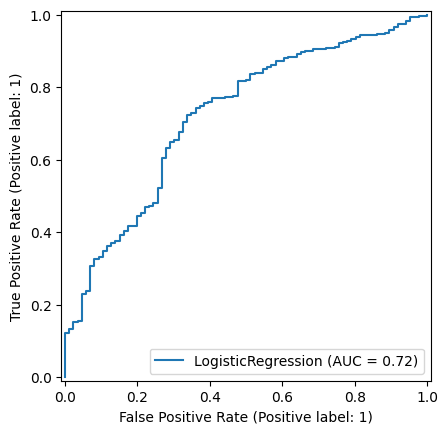

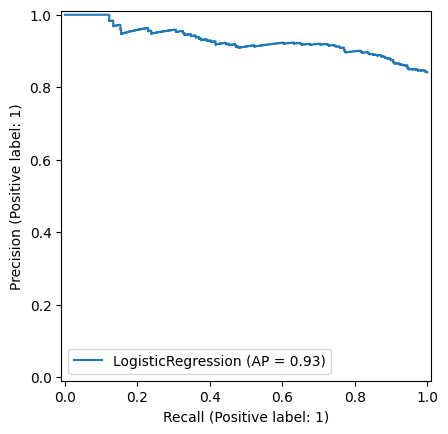

In [54]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [55]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [56]:
roc_df.to_csv(
    "roc/infection.tsv",
    sep="\t"
)

# Probability Prediction

In [57]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [58]:
predict_data = predict_data[protein_columns].copy()

In [59]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [60]:
predict_data['infection_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [61]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['infection_probability']
).reset_index()

In [62]:
predict_data[['infection_probability']].to_csv(
    "predictions_test/infection.tsv",
    sep="\t"
)

<Axes: xlabel='infection_probability', ylabel='Count'>

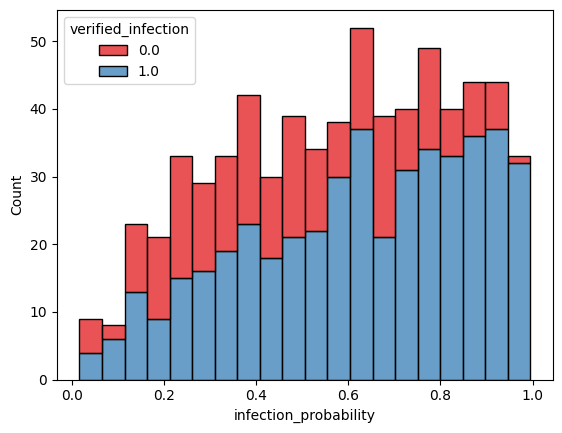

In [63]:
sns.histplot(
    data=design_matrix_test,
    x="infection_probability",
    hue="verified_infection",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [64]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [65]:
val_data = val_data[protein_columns].copy()

In [66]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [67]:
val_data['infection_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [68]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['infection_probability']
).reset_index()

In [69]:
val_data[['infection_probability']].to_csv(
    "predictions_val/infection.tsv",
    sep="\t"
)

<Axes: xlabel='infection_probability', ylabel='Count'>

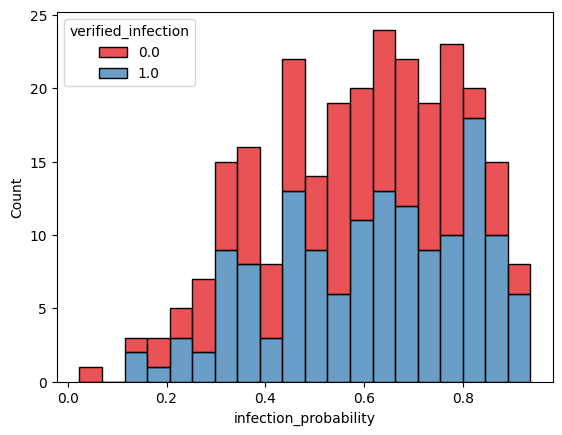

In [70]:
sns.histplot(
    data=design_matrix_val,
    x="infection_probability",
    hue="verified_infection",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [71]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [72]:
hero_data = hero_data[protein_columns].copy()

In [73]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [74]:
hero_data['infection_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [75]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['infection_probability']
).reset_index()

In [76]:
hero_data[['infection_probability']].to_csv(
    "predictions_external/infection.tsv",
    sep="\t"
)

<Axes: xlabel='infection_probability', ylabel='Count'>

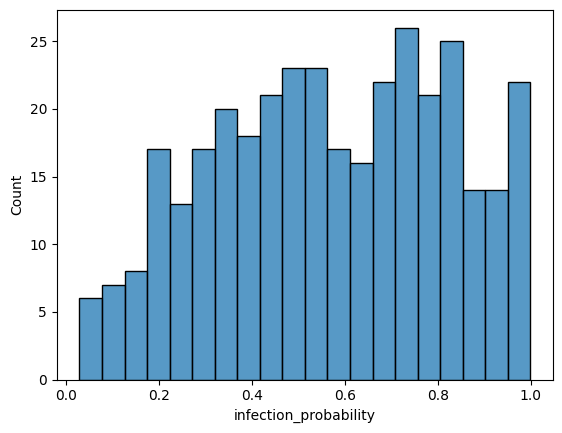

In [77]:
sns.histplot(
    data=hero_data,
    x="infection_probability",
    #hue="sofa_infection_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [78]:
from joblib import dump


with open("models/infection_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/infection_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
